## IV Failure Classification with Neural Networks

In [1]:
import os
import sys
sys.path.append('..')
IV_path = os.path.join('..', 'pvops', 'iv')
sys.path.append(IV_path)

from pvops.iv import simulator, extractor, preprocess
from pvops.iv.models import nn

Using TensorFlow backend.





In [2]:
iv_col_dict = {
    "mode": "mode",
    "current": "current",            # Populated in simulator
    "voltage": "voltage",            # Populated in simulator
    "irradiance": "E",               # Populated in simulator
    "temperature": "T",              # Populated in simulator
    "power": "power",                # Populated in preprocess
    "derivative": "derivative",      # Populated in feature_generation
    "current_diff": "current_diff",  # Populated in feature_generation
}

### Step 1: Collect your IV curves. 

In this case, we simulate some curves, but you can replace this step by reading in your own data, if wanted.

In [3]:
def define_failure_at_environment(sim, E, Tc, N_samples = 10):

    def namer(name):
        suffix = f"-{E}_{Tc}"
        return name + suffix
    
    sim.pristine_condition = {'identifier': 'pristine',
                              'E': E,
                              'Tc': Tc,
                              'Rsh_mult': 1,
                              'Rs_mult': 1,
                              'Io_mult': 1,
                              'Il_mult': 1,
                              'nnsvth_mult': 1,
                              }
    condition = {'identifier':namer('weathered_pristine')}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_weathered_pristine'))
    condition = {'identifier':namer('shade'),'Il_mult':0.6}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_shading'))
    condition = {'identifier':namer('cracking'),'Rs_mult':1.5}
    sim.add_preset_conditions('complete', condition, save_name = namer('Complete_cracking'))

    dicts = {'Il_mult':{'mean': 0.6,
                        'std': 0.7,
                        'low': 0.33,
                        'upp': 0.95,
                        }
            }
    sim.generate_many_samples(namer('shade'), N_samples, dicts)

    dicts = {
            'Rs_mult':{'mean':1.3,
                        'std':0.6,
                        'low':1.1,
                        'upp':1.8
                        },
            'Rsh_mult':{'mean':0.5,
                        'std':0.6,
                        'low':0.3,
                        'upp':0.7
                        }
            }
    sim.generate_many_samples(namer('cracking'), N_samples, dicts)

    sim.build_strings({
                    namer('Partial Soiling (1M)'): [namer('Complete_weathered_pristine')]*11 + [namer('Complete_shading')]*1,
                    namer('Partial Soiling (6M)'): [namer('Complete_weathered_pristine')]*6 + [namer('Complete_shading')]*6,
                    namer('Cell cracking (4M)'): [namer('Complete_weathered_pristine')]*8 + [namer('Complete_cracking')]*4,
                    })
    return sim


In [4]:
import numpy as np

sim = simulator.Simulator(
                pristine_condition = {
                                        'identifier': 'pristine',
                                        'E': 1000,
                                        'Tc': 50,
                                        'Rsh_mult': 1,
                                        'Rs_mult': 1,
                                        'Io_mult': 1,
                                        'Il_mult': 1,
                                        'nnsvth_mult': 1,
                                    })

sim.build_strings({'Pristine array': ['pristine']*12})

Tc = 35
for E in np.arange(200,1100,100):
    for Tc in np.arange(35,60,5):
        define_failure_at_environment(sim, E, Tc, N_samples = 25)
sim.simulate()

Simulating cells:   0%|          | 0/136 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 136/136 [00:00<00:00, 68013.04it/s]


In [5]:
df = sim.sims_to_df(focus=['string'], cutoff=True)
df.head()

,current,voltage,E,T,mode,level
0,"[9.214203000284689, 9.210691359222285, 9.20726...","[3.834932371660216e-12, 11.207809937682319, 22...",1000.0,50.0,Pristine array,string
1,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
2,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
3,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string
4,"[1.828797118809955, 1.8281227256242998, 1.8274...","[9.598528688982285, 19.45539770828682, 29.0763...",200.0,35.0,Partial Soiling (1M)-200_35,string


In [6]:
df['mode'] = [x.split('-')[0] for x in df['mode']]

In [7]:
# Irradiance & Temperature correction, and normalize axes
prep_df = preprocess.preprocess(df, 0.05, iv_col_dict, resmpl_cutoff=0.03, correct_gt=True, normalize_y=False, CECmodule_parameters=sim.module_parameters, n_mods=12, gt_correct_option=3)
# Shuffle
bigdf = prep_df.sample(frac=1).reset_index(drop=True)
bigdf.dropna(inplace=True)
bigdf.head(n=2)


,mode,current,voltage,power,E,T
0,Partial Soiling (6M),"[9.212872754228675, 9.200665095290365, 9.18845...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.27638618262686027, 0.7360532076232292, 1.19...",200.0,40.0
1,Cell cracking (4M),"[9.2095126789014, 9.200755720282482, 9.1928563...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.276285380367042, 0.7360604576225985, 1.1950...",900.0,40.0


In [8]:
# Feature generation
feat_df = nn.feature_generation(bigdf, iv_col_dict)
feat_df.head(n=2)

..\pvops\iv\models\nn.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  False, True], inplace=True)
..\pvops\iv\models\nn.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[current_diff_col] = diffs
..\pvops\iv\models\nn.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[derivative_col] = finite_derivative

,mode,current,voltage,power,E,T,current_diff,derivative
0,Partial Soiling (6M),"[9.212872754228675, 9.200665095290365, 9.18845...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.27638618262686027, 0.7360532076232292, 1.19...",200.0,40.0,"[-0.0026718996918067006, 0.002865444699638786,...","[0.0, -0.012207658938310217, -0.01221410496392..."
1,Cell cracking (4M),"[9.2095126789014, 9.200755720282482, 9.1928563...","[0.03, 0.08, 0.13, 0.18000000000000002, 0.23, ...","[0.276285380367042, 0.7360604576225985, 1.1950...",900.0,40.0,"[0.0006881756354690793, 0.002774819707521914, ...","[0.0, -0.008756958618917565, -0.00789939073044..."


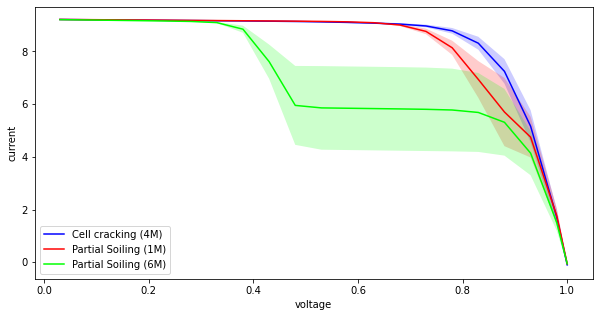

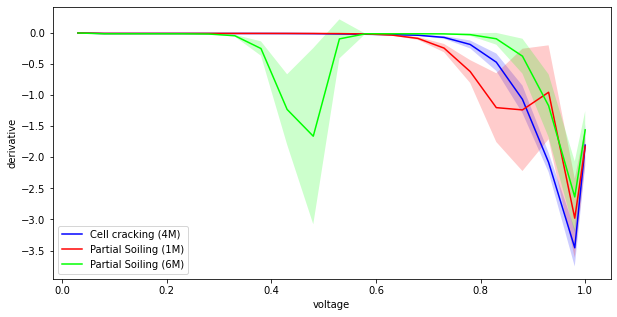

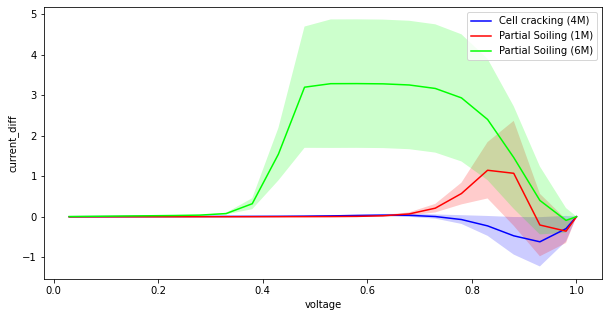

In [9]:
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['current'],
                       iv_col_dict)
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['derivative'],
                       iv_col_dict)
fig = nn.plot_profiles(feat_df,
                       iv_col_dict['voltage'],
                       iv_col_dict['current_diff'],
                       iv_col_dict)

In [10]:
nn_config = {
    # NN parameters
    "model_choice": "1DCNN", # or "LSTM_multihead"
    "params": ['current', 'power', 'derivative', 'current_diff'],
    "dropout_pct": 0.5,
    "verbose": 1,
    # Training parameters
    "train_size": 0.9,
    "shuffle_split": True,
    "balance_tactic": 'truncate',
    "n_CV_splits": 5,
    "batch_size": 8,
    "max_epochs": 100,
    # LSTM parameters
    "use_attention_lstm": False,
    "units": 50,
    # 1DCNN parameters
    "nfilters": 64,
    "kernel_size": 12,
}

nn.classify_curves(feat_df, iv_col_dict, nn_config)

Balance data by mode:
	[Class Cell cracking (4M)]: Resampled, 1170 == 1170
	[Class Partial Soiling (6M)]: Resampled, 1170 == 1170
	[Class Partial Soiling (1M)]: Resampled, 1170 == 1170


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               64100     
_________________________________________________________________
dense_2 (Dense)              (None, 